In [10]:
import numpy as np
import matplotlib.pyplot as plt
from vtl.Photo import Photometry
from scipy.interpolate import interp1d
import fsps
import pandas as pd
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

In [2]:
AGE=np.arange(.15,6.05,.05)
age=np.arange(.5,6.1,.1)

In [10]:
sp = fsps.StellarPopulation(imf_type=0,tpagb_norm_type=0,zcontinuous=1,logzsol=np.log10(0.019/0.019), sfh=4,tau=0.2)
wv,fl=np.array(sp.get_spectrum(tage=.15,peraa=True))

In [11]:
sp.get_mags(tage=.15,bands=['sdss_g'])

array([ 2.19184375])

In [17]:
m19_g =np.load('../data/m0.019_gbf.npy')

In [8]:
m19_g.shape

(31, 118)

In [12]:
10**(-2.19184375/2.5)

0.13281970154060663

In [25]:
AGE[57]

3.0000000000000009

In [29]:
gbf = m19_g[5]

In [27]:
10**(-(m19_g[5][57]+48.6)/2.5)*(3E18/4770**2
                               )

3.6141618527683265e-20

In [3]:
wv,fl = np.load('/Users/vestrada/bc03_models_for_fit/bc03_spec/m0.02_a3.0_dt8.7_spec.npy')

In [4]:
wvf,flf = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a3.0_dt8.7_spec.npy')

(0, 0.00025)

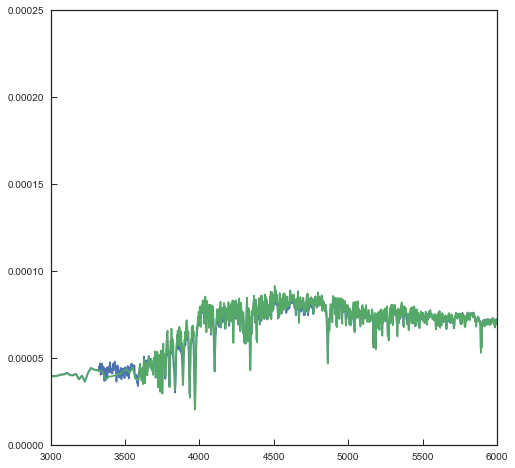

In [14]:
%matplotlib inline

plt.figure(figsize = [8,8])
plt.plot(wv,fl*.3E7)
plt.plot(wvf,flf)
plt.xlim(3000,6000)
plt.ylim(0,0.00025)


In [15]:
bcphot = Photometry(wv,fl*.3E7,[0],157)
bcphot.Get_Sensitivity()
bcphot.Photo_model(wv,fl*.3E7)

In [16]:
bcphot.mphoto

7.5831141396520509e-05

In [9]:
fsphot = Photometry(wvf,flf,[0],157)
fsphot.Get_Sensitivity()
fsphot.Photo_model(wvf,flf)

In [10]:
fsphot.mphoto

7.7844914095656626e-05

In [56]:
gbp=np.zeros(age.size)
for i in range(age.size):
    wvf,flf = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a%s_dt8.7_spec.npy' % age[i])
    fsphot = Photometry(wvf,flf,[0],157)
    fsphot.Get_Sensitivity()
    fsphot.Photo_model(wvf,flf)
    gbp[i]=fsphot.mphoto
    
gbpb=np.zeros(AGE.size)
for i in range(AGE.size):
    wv,fl = np.load('/Users/vestrada/bc03_models_for_fit/bc03_spec/m0.02_a%s_dt8.7_spec.npy' % AGE[i])
    bcphot = Photometry(wv,fl,[0],157)
    bcphot.Get_Sensitivity()
    bcphot.Photo_model(wv,fl)
    gbpb[i]=bcphot.mphoto

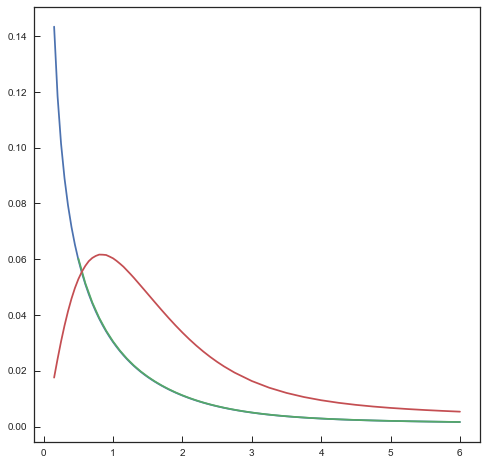

In [57]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(AGE,gbf)
plt.plot(age,gbp*6.45E1)
plt.plot(AGE,gbpb*6.45E8)

In [58]:
[0.004/0.02,0.008/0.02,0.02/0.02]

[0.2, 0.4, 1.0]

In [59]:
[.2*.019,.4*.019,.019]

[0.0038, 0.0076, 0.019]

In [3]:
Zfs = np.array([0.004,0.008,0.019])
be_tau = np.array([8.0,8.48,8.7,8.85,8.95,9.01,9.11,9.18,9.23,9.28])
be_tau_id = np.array([1,3,5,7,9,11,13,15,17,19])


for i in range(Zfs.size):
    new_grid=np.zeros([be_tau.size,AGE.size])
    gbf=np.load('../data/m%s_gbf.npy' % Zfs[i])
    for ii in range(be_tau.size):
        new_grid[ii]=gbf[be_tau_id[ii]]
        
    np.save('../BE/m%s_gbf' % Zfs[i],new_grid)

In [3]:
Zbc = np.array([0.004,0.008,0.02])
be_tau = [8,8.48,8.7,8.85,8.95,9.04,9.11,9.18,9.23,9.28]

for i in range(Zbc.size):
    gb_grid=np.zeros([np.array(be_tau).size,AGE.size])
    for ii in range(np.array(be_tau).size):
        for iii in range(AGE.size):
            wv,fl = np.load('/Users/Vince.ec/bc03_models_for_fit/bc03_spec/m%s_a%s_dt%s_spec.npy' 
                            % (Zbc[i],AGE[iii],be_tau[ii]))
            bcphot = Photometry(wv,fl,[0],157)
            bcphot.Get_Sensitivity()
            bcphot.Photo_model(wv,fl)
            gb_grid[ii][iii]=bcphot.mphoto
    np.save('../BE/bcm%s_gbf' % Zbc[i],gb_grid)

# Extract LWA FOR NEW FS AND BCO3

In [8]:
def SFH(AGE,TAU):
    return AGE*np.exp(-AGE/TAU)
def LWA(dist,tau):
    dst = np.append(2*dist[0]-dist[1],dist)
    
    iage = np.arange(0,6.01,.01)

    hiressfh=SFH(iage,tau)
    idst = interp1d(np.append(0,AGE),dst)(iage)
    
    top = np.zeros(len(idst)-1)
    bottom = np.zeros(len(idst)-1)
    
    for i in range(len(idst)-1):
        top[i] = np.trapz(hiressfh[0:i+1] * idst[0:i+1] * (iage[i+1] - iage[0:i+1]),iage[0:i+1])
        bottom[i] = np.trapz(hiressfh[0:i+1] * idst[0:i+1],iage[0:i+1])
    
    lwa = interp1d(np.arange(0.01,6.01,.01),top/bottom)(age)
    
    return lwa

In [14]:
be_tau = np.array([8.0,8.48,8.7,8.85,8.95,9.01,9.11,9.18,9.23,9.28])
ultau=10**(be_tau-9)
Zfs = np.array([0.004,0.008,0.019])
Zbc = np.array([0.004,0.008,0.02])
AGE=np.arange(.15,6.05,.05)
age=np.arange(.5,6.1,.1)

In [23]:
fs_grid = np.zeros([Zfs.size,AGE.size,ultau.size])
bc_grid = np.zeros([Zfs.size,AGE.size,ultau.size])
for i in range(Zfs.size):
    fs_grid[i]=np.load('../BE/m%s_gbf.npy' % Zfs[i]).T
    bc_grid[i]=np.load('../BE/bcm%s_gbf.npy' % Zbc[i]).T

In [19]:
testfs = LWA(fs_grid[2].T[8][::-1],ultau[8])
testbc = LWA(bc_grid[2].T[8][::-1],ultau[8])

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


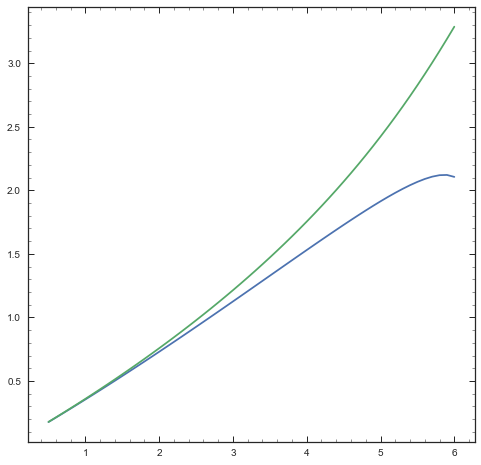

In [20]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(age,testfs)
plt.plot(age,testbc)

In [25]:
fs_age_conv= np.zeros([Zfs.size,age.size,ultau.size])
bc_age_conv= np.zeros([Zfs.size,age.size,ultau.size])

for i in range(Zfs.size):
    fs_age_grid = np.zeros([ultau.size,age.size])
    bc_age_grid = np.zeros([ultau.size,age.size])
    for ii in range(ultau.size):
        fs_age_grid[ii] = LWA(fs_grid[i].T[ii][::-1],ultau[ii])
        bc_age_grid[ii] = LWA(bc_grid[i].T[ii][::-1],ultau[ii])
    fs_age_conv[i] = fs_age_grid.T
    bc_age_conv[i] = bc_age_grid.T

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


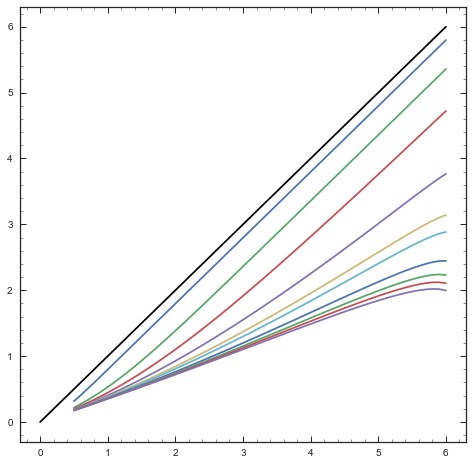

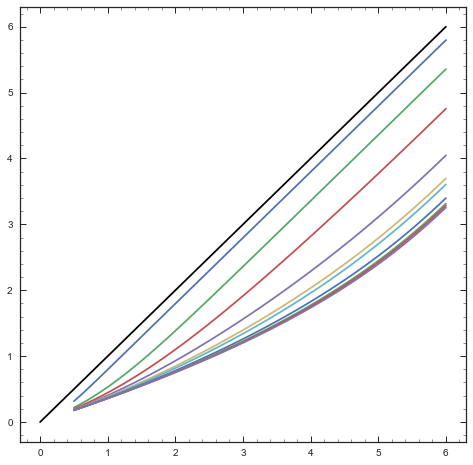

In [29]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot([0,6],[0,6],'k')
for i in range(ultau.size):
    plt.plot(age,fs_age_conv[2].T[i])
    
plt.figure(figsize=[8,8])
plt.plot([0,6],[0,6],'k')
for i in range(ultau.size):
    plt.plot(age,bc_age_conv[2].T[i])

In [30]:
np.save('../BE/FS_age_conv',fs_age_conv)
np.save('../BE/BC_age_conv',bc_age_conv)